# MODEL UNET




In [0]:
import os
import cv2
import sys
import json
import random
import pylab
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#Tensorflow backend
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout


In [3]:
# Test GPU to be initialized
tf.test.gpu_device_name()

''

In [4]:
# GPU accelerator info
!nvidia-smi 

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
# Keras version
keras.__version__

'2.3.0-tf'

### MOUNTING DRIVE FILE SYSTEM


In [6]:
from google.colab import drive
drive_directory = '/content/gdrive'
drive.mount(drive_directory)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Unzip the uploaded data.zip archive**




In [0]:
# data_directory = '/Unet.zip'
# path_train = 'content/gdrive/My Drive/Lystox_data/Unet.zip'
# destination =  "/content/gdrive/My Drive/Lystox_data/Unet/Unet/"

#!unzip -uq "/content/gdrive/My Drive/Lystox_data/12_03_2020_AUG.zip" -d "/content/gdrive/My Drive/Lystox_data/Unet/Unet/"


### DATAGENERATOR





In [0]:
class Datagenerator(keras.utils.Sequence):
  """
  Datagenerator class represents Data generator
  inherited from keras.utils.Sequence
  which loads images and corresponding masks
  into user defined size batches.
  """

  def __init__(self, ids, path, batch_size=32, image_size=288, image_format='.png', c_space='rgb'):
    self.ids = ids   # Id of directory with image and mask
    self.path = path # Path to train or test images
    self.batch_size = batch_size
    self.image_size = image_size
    self.image_format = image_format
    self.c_space = c_space
    self.on_epoch_end()
    
  def __load__(self, id_name):
    """
    Function loads specified id_name image and
    corresponding mask.
    If user defined other c_space format than RGB,
    conversion to the c_space is provided and 
    returned the loaded image with the mask

    param: id_name - name of image directorz to load image/mask from
    return: 2 x np.array() 
    """
    image_path = os.path.join(self.path, id_name, 'img',  id_name) + self.image_format
    mask_path = os.path.join(self.path, id_name, 'mask', id_name + '_mask') + self.image_format
    
    #Load images from disk
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    
    #Conversion to defined color space
    if self.c_space == 'lab':
      image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    elif self.c_space == 'hsv':
      image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    #Data type conversion to np.float64
    image =  image/255.0

    if mask is not None:
      mask = mask/255.0
      mask = mask.reshape((self.image_size, self.image_size, 1))
    
    return image,mask

  def __getitem__(self, index):
    """
    Function loads images and masks
    to the specified batch in the index

    param: index - index to start loading from
    return: 2x np.array (4D)
    """

    if (index+1) * self.batch_size > len(self.ids):
        self.batch_size = len(self.ids) - index * self.batch_size
    
    # Get names of image in specified index
    files_batch = self.ids[index*self.batch_size : (index+1) * self.batch_size] # Select img from train directory
    
    images = []
    mask = []
    
    # Load them to lists
    for id_name in files_batch:
        _img, _mask = self.__load__(id_name)
        images.append(_img)
        mask.append(_mask)
    
    # Convert to numpy arrays
    images = np.array(images)
    mask = np.array(mask)
    
    return images, mask

  def on_epoch_end(self):
      pass

  def __len__(self):
    """
    Function returns number
    of batches from user defined
    directory
    """

    return int(np.ceil(len(self.ids)/float(self.batch_size)))

         

## HYPERPARAMETERS


In [9]:
image_size = 288
train_path = '/content/gdrive/My Drive/Lystox_data/Unet/Unet/Data/Train/'
eval_path = '/content/gdrive/My Drive/Lystox_data/Unet/Unet/Data/Evaluation'
test_path = '/content/gdrive/My Drive/Lystox_data/Unet/Unet/Data/Test'

wsi_path = '/content/gdrive/My Drive/Lystox_data/Unet/Unet/Data/WSI'

epochs = 20
batch_size = 16
dropout = 0.3
color_space = 'lab'

#Load all image ids
train_ids = next(os.walk(train_path))[1] #Train ids directories
eval_ids = next(os.walk(eval_path))[1] #Eval ids directories
test_ids = next(os.walk(test_path))[1] #Test ids directories

print(len(train_ids))
print(len(eval_ids))
print(len(test_ids))

6030
400
200


## DATAGENERATORS INITIALIZATION

In [10]:
# Load 3 different generators for training/validation/test part

gen_train = Datagenerator(train_ids, train_path, batch_size, c_space = color_space)
gen_eval = Datagenerator(eval_ids, eval_path, batch_size, c_space=color_space)
gen_test = Datagenerator(test_ids, test_path, batch_size, c_space=color_space)

# Test them
x,y = gen_train.__getitem__(0)
print(x.shape, y.shape)
x_e, y_e = gen_eval.__getitem__(0)
print(x_e.shape, y_e.shape)
x_t, y_t = gen_test.__getitem__(0)
print(x_t.shape, y_t.shape)

(16, 288, 288, 3) (16, 288, 288, 1)
(16, 288, 288, 3) (16, 288, 288, 1)
(16, 288, 288, 3) (16, 288, 288, 1)


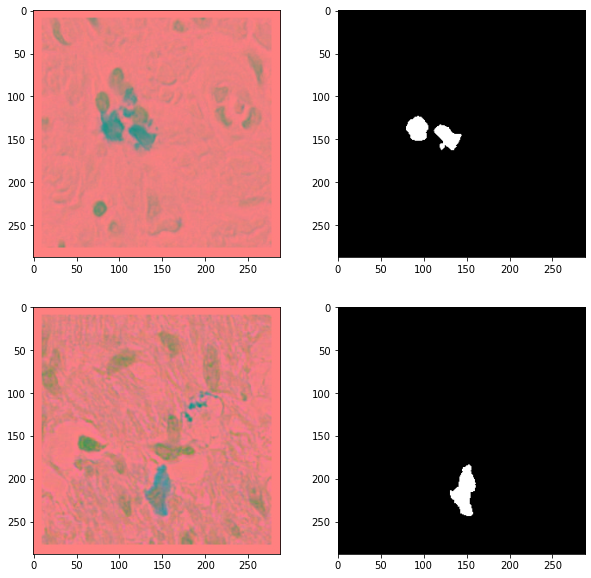

In [11]:
#Load  est sample to show chosen color format
figs = 2
fig, ax = plt.subplots(nrows=figs, ncols=2,figsize=(10,10))
for i,row in enumerate(ax):
  idx = np.random.randint(0, batch_size)
  row[0].imshow(x_t[idx])
  row[1].imshow(y_t[idx].reshape(image_size,image_size), cmap='gray')

## UNET ARCHITECTURE

![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

*Source - https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png*

In [0]:
# Model layers
def down_block(x, filters, dropout=0.2, kernel_size =(3,3), padding='same', strides=1):

    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c = keras.layers.Dropout(dropout)(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
    p = keras.layers.MaxPool2D((2,2), (2,2))(c)
    
    return c,p

def up_block(x, skip, filters, dropout=0.2, kernel_size=(3,3), padding='same', strides=1):

    up = keras.layers.UpSampling2D((2,2))(x)       #Transpose convolution
    concat = keras.layers.Concatenate()([up,skip]) #Concatenation with previous contracting part
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)

    return c

def bottom(x, filters, kernel_size=(3,3), padding='same', strides=1):

    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)

    return c

In [0]:
def Unet():

    #Filters
    f = [16, 32, 64, 128, 256]

    inputs = keras.layers.Input((image_size, image_size, 3))

    #Contracting part
    c1,p1 = down_block(inputs, f[0], dropout) 
    c2,p2 = down_block(p1, f[1], dropout) 
    c3,p3 = down_block(p2, f[2], dropout)
    c4,p4 = down_block(p3, f[3], dropout)
    
    bn = bottom(p4, f[4])

    #Expansion part
    u1 = up_block(bn, c4, f[3], dropout)
    u2 = up_block(u1, c3, f[2], dropout)
    u3 = up_block(u2, c2, f[1], dropout)
    u4 = up_block(u3, c1, f[0], dropout)

    #Final layer of the model
    outputs = keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(u4)
    
    model = keras.models.Model(inputs, outputs)
    return model

## TRAINING

In [0]:
# Add metric
IoU = tf.keras.metrics.MeanIoU(num_classes=2)

In [15]:

model = Unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',IoU]) #binary_crossentropy
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 288, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 288, 288, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 288, 288, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 288, 288, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [16]:
train_steps = len(train_ids) // batch_size #Iterations
valid_steps = len(eval_ids) // batch_size #Iterations
test_steps = len(test_ids) // batch_size #Iterations

print(f'Train steps: {train_steps}')
print(f'Valid steps: {valid_steps}')
print(f'Eval steps: {test_steps}')
print(f'Number of epochs: {epochs}')

Train steps: 376
Valid steps: 25
Eval steps: 12
Number of epochs: 20


In [0]:
with tf.device("/gpu:0"):
  model_hist = model.fit(gen_train, validation_data=gen_eval, epochs=epochs)

Epoch 1/20
 30/377 [=>............................] - ETA: 1:32:03 - loss: 0.1270 - acc: 0.9771 - mean_io_u: 0.4945

In [0]:

#tf.keras.backend.clear_session() To restart session

In [0]:
model_hist.history.keys()

In [0]:
def plot_metrics(history):
  """Function plots model metrics
     in subplots

  """

  metrics =  history.history.keys()

  for i, metric in enumerate(metrics):

    plt.subplot(3,2,i+1)
    plt.plot(history.epoch,  history.history[metric], label='Train')
    plt.plot(history.epoch, history.history[metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0.3,1])

    plt.legend()

In [0]:
plot_metrics(model_hist)

## SAVING MODEL AND HISTORY

In [0]:
#Saving the model

model_name = 'model_unet_rgb_d_0.3_e_20'
format = '.h5'
directory = ''
file = model_name + '_hist.json'

model.save('/content/gdrive/My Drive/Lystox_data/Unet/Unet/' + directory + model_name + format)  #'HDF5 file format'

with open('/content/gdrive/My Drive/Lystox_data/Unet/Unet/' + directory + file, 'w') as f:
    json.dump(str(model_hist.history), f)

## LOADING MODEL FROM Drive


In [0]:
#Loading the model

model_name = 'model_unet_rgb_d_0.4_e_10'
history  = 'model_unet_rgb_d_0.4_e_10hsv_e_10_drop_0.4_hist.json'
format = '.h5'
directory = 'model_drop_0.4/'

def load_from_drive(model_name, directory, hist):
  model_loaded = keras.models.load_model('/content/gdrive/My Drive/Lystox_data/Unet/Unet/' + directory + model_name + format)

  with open ('/content/gdrive/My Drive/Lystox_data/Unet/Unet/' + directory + hist, 'r') as f:
    model_hist = json.load(f)

  return model_loaded, model_hist

In [0]:
model, hist = load_from_drive(model_name, directory, history)

In [0]:
model.summary()

In [0]:
model_name = 'model_unet_lab_2.0.h5'
model_lab = keras.models.load_model('/content/gdrive/My Drive/Lystox_data/Unet/Unet/' + model_name)

In [0]:
model_lab.summary()

In [0]:
model_name = 'model_unet_hsv_2.0.h5'
model_hsv = keras.models.load_model('/content/gdrive/My Drive/Lystox_data/Unet/Unet/' + model_name)

## METRICS

In [0]:
def jaccard(a, mask):
  a_n = np.zeros(a.shape, dtype=np.float32)
  b_n = np.zeros(a.shape ,dtype=np.float32)

  a_n[a>0] = 1.
  a_n[a<=0] = 0.

  b_n[mask>0] = 1
  b_n[mask<=0] = 0.

  if a_n.sum() == 0 and b_n.sum() == 0:
    return 1.
  else:
    return (a_n * b_n).sum() / ((a_n + b_n).sum() - (a_n * b_n).sum())

In [0]:
def dice(a, mask):
  a_n = np.zeros(a.shape, dtype=np.float32)
  b_n = np.zeros(a.shape, dtype=np.float32)

  a_n[a>0] = 1.
  a_n[a<=0] = 0.

  b_n[mask>0] = 1
  b_n[mask<=0] = 0.

  if a_n.sum() == 0 and b_n.sum() == 0:
    return 1.
  else:
    return 2 * (a_n * b_n).sum() / (a_n + b_n).sum()

In [0]:
def threshold(img, thresh=0.15):
  new = np.zeros(img.shape,dtype=np.uint8)
  new[img > thresh] = 255
  new[img <= thresh] = 0

  return new

In [0]:
#Morph opening
def morph_open(img, size):
  struct_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
  img_opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, struct_elem)
  return img_opened

## PREDICTED EXAMPLES

(8, 288, 288, 3) (8, 288, 288, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.6693277359008789
Dice coefficient is: 0.8019129121570602


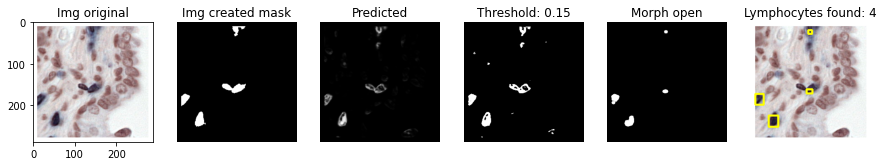

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.0
Dice coefficient is: 0.0


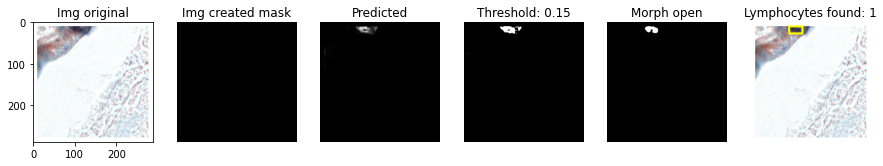

Jaccard coefficient is: 0.698924720287323
Dice coefficient is: 0.8227848101265823


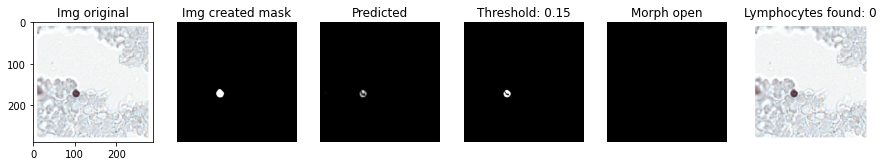

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.2732003331184387
Dice coefficient is: 0.42915531335149865


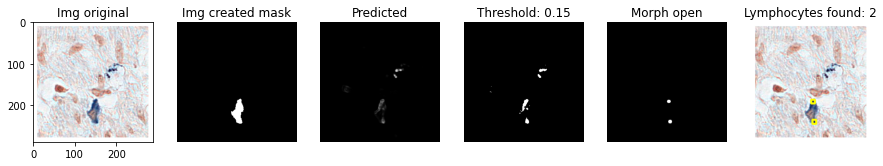

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.6834008097648621
Dice coefficient is: 0.8119288119288119


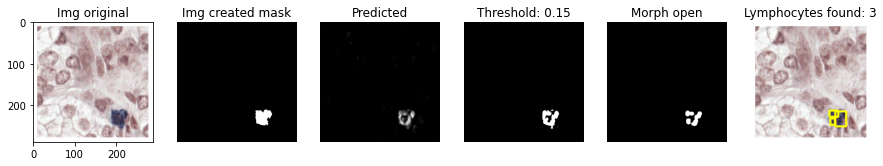

Jaccard coefficient is: 1.0
Dice coefficient is: 1.0


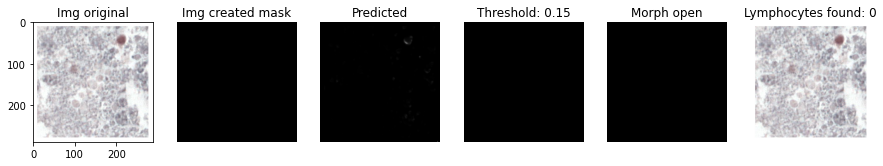

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.0
Dice coefficient is: 0.0


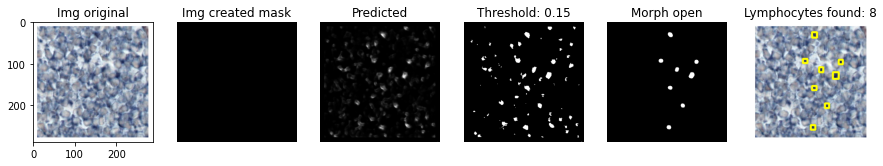

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.8516320586204529
Dice coefficient is: 0.9198717948717948


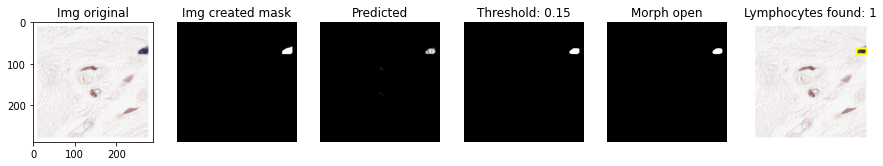

In [0]:
index = 0
batch = 8
gen_eval = Datagenerator(test_ids, test_path, batch, c_space='rgb')
x,y = gen_eval.__getitem__(index)
print(x.shape,y.shape)
result2 = model.predict(x)


for i in range(0, len(x)):

    #Bounding box to orig img:
    orig = x[i].copy()
    new = np.zeros((288,288), dtype=np.uint8)
    tmp = result2[i].copy()
    tmp = tmp.reshape(288,288)
    threshold = 0.15
    pos = tmp >= threshold
    neg = tmp < threshold
    new[pos] = 255
    new[neg] = 0

    morphed = morph_open(new, 9)

    cnt, _ = cv2.findContours(image=morphed,
                              mode=cv2.RETR_EXTERNAL,
                              method=cv2.CHAIN_APPROX_SIMPLE)
    bin = np.zeros((288,288), dtype=np.uint8)
    bin = cv2.drawContours(bin, cnt, -1, (255, 255, 255), cv2.FILLED)

    ex = []
    for c in cnt:
      if cv2.contourArea(c) > 10:
        ex.append(c)

    for c in ex:
      a,b,c,d = cv2.boundingRect(c)
      cv2.rectangle(orig, (a,b),(a+c,b+d),(255,255,0),4)

    print('Jaccard coefficient is: {:2}'.format(jaccard(new,y[i].reshape(288,288))))
    print('Dice coefficient is: {:2}'.format(dice(new,y[i].reshape(288,288))))

    fig, rows = plt.subplots(nrows=1, ncols=6, figsize=(15,15))
    rows[0].imshow(x[i])
    rows[0].set_title('Img original')
    rows[1].imshow(y[i].reshape(288,288), cmap='gray')
    rows[1].set_title('Img created mask')
    rows[1].axis('off')
    rows[2].imshow(result2[i].reshape(288,288), cmap='gray')
    rows[2].set_title('Predicted')
    rows[2].axis('off')
    rows[3].imshow(new, cmap='gray')
    rows[3].set_title('Threshold: {}'.format(threshold))
    rows[3].axis('off')
    rows[4].imshow(morphed, cmap='gray')
    rows[4].set_title('Morph open')
    rows[4].axis('off')
    rows[5].imshow(orig)
    rows[5].set_title('Lymphocytes found: {}'.format(len(ex)))
    rows[5].axis('off')

    plt.show()
    #plt.savefig('/content/gdrive/My Drive/Lystox_data/Unet/Unet/' + 'test_data_' + str(i) +'.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 288, 288, 3) (8, 288, 288, 1)
Jaccard coefficient is: 0.21591949462890625
Dice coefficient is: 0.3551542513167795


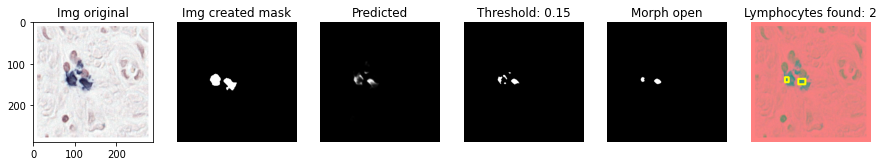

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.4511568248271942
Dice coefficient is: 0.6217891939769707


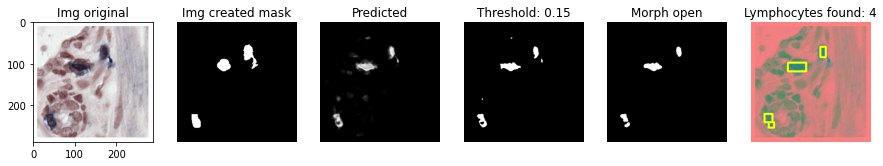

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.6580376029014587
Dice coefficient is: 0.7937547217325611


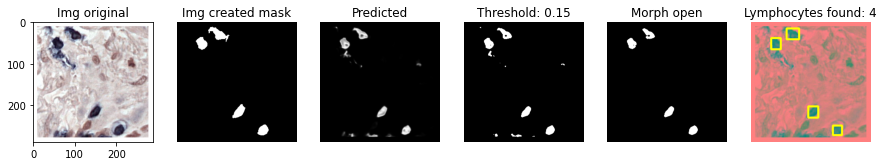

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.13350126147270203
Dice coefficient is: 0.23555555555555555


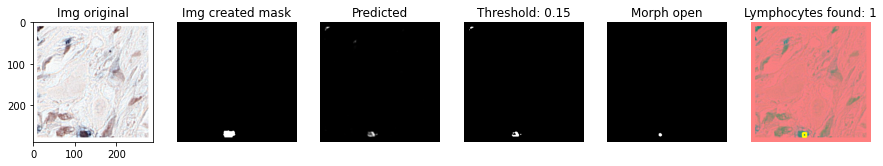

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.7096219658851624
Dice coefficient is: 0.8301507537688442


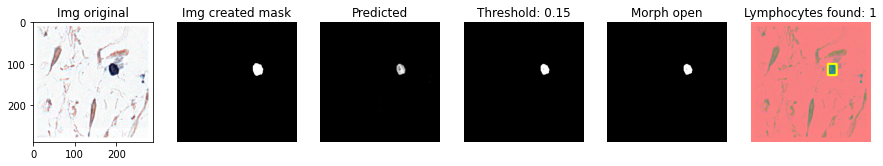

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.24911661446094513
Dice coefficient is: 0.3988684582743989


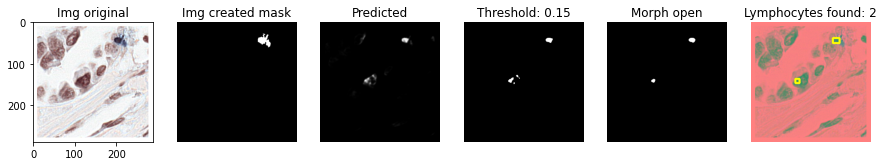

Jaccard coefficient is: 0.26794055104255676
Dice coefficient is: 0.42263898191560617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


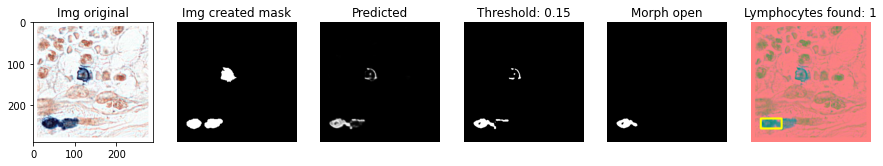

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.06534893065690994
Dice coefficient is: 0.12268080272624006


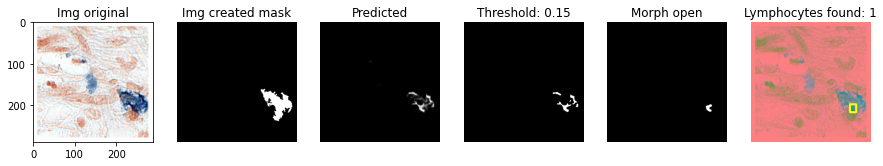

In [0]:
index = 1
batch = 8
gen_eval = Datagenerator(test_ids, test_path, batch, c_space='lab')
gen_eval_rgb = Datagenerator(test_ids, test_path, batch, c_space='rgb')
x,y = gen_eval.__getitem__(index)
x_rgb,y_rgb = gen_eval_rgb.__getitem__(index)
print(x.shape,y.shape)
result2 = model.predict(x)


for i in range(0, len(x)):

    #Bounding box to orig img:
    orig = x[i].copy()
    new = np.zeros((288,288), dtype=np.uint8)
    tmp = result2[i].copy()
    tmp = tmp.reshape(288,288)
    threshold = 0.15
    pos = tmp >= threshold
    neg = tmp < threshold
    new[pos] = 255
    new[neg] = 0

    morphed = morph_open(new, 7)

    cnt, _ = cv2.findContours(image=morphed,
                              mode=cv2.RETR_EXTERNAL,
                              method=cv2.CHAIN_APPROX_SIMPLE)
    bin = np.zeros((288,288), dtype=np.uint8)
    bin = cv2.drawContours(bin, cnt, -1, (255, 255, 255), cv2.FILLED)

    ex = []
    for c in cnt:
      if cv2.contourArea(c) > 10:
        ex.append(c)

    for c in ex:
      a,b,c,d = cv2.boundingRect(c)
      cv2.rectangle(orig, (a,b),(a+c,b+d),(255,255,0),4)

    print('Jaccard coefficient is: {:2}'.format(jaccard(bin,y[i].reshape(288,288))))
    print('Dice coefficient is: {:2}'.format(dice(bin,y[i].reshape(288,288))))

    fig, rows = plt.subplots(nrows=1, ncols=6, figsize=(15,15))
    rows[0].imshow(x_rgb[i])
    rows[0].set_title('Img original')
    rows[1].imshow(y[i].reshape(288,288), cmap='gray')
    rows[1].set_title('Img created mask')
    rows[1].axis('off')
    rows[2].imshow(result2[i].reshape(288,288), cmap='gray')
    rows[2].set_title('Predicted')
    rows[2].axis('off')
    rows[3].imshow(new, cmap='gray')
    rows[3].set_title('Threshold: {}'.format(threshold))
    rows[3].axis('off')
    rows[4].imshow(morphed, cmap='gray')
    rows[4].set_title('Morph open')
    rows[4].axis('off')
    rows[5].imshow(orig)
    rows[5].set_title('Lymphocytes found: {}'.format(len(ex)))
    rows[5].axis('off')

    plt.show()
    #plt.savefig('/content/gdrive/My Drive/Lystox_data/Unet/Unet/' + 'test_data_' + str(i) +'.png')

In [0]:
index = 7
batch = 8
gen_eval = Datagenerator(test_ids, test_path, batch, c_space='lab')
x,y = gen_eval.__getitem__(index)
print(x.shape,y.shape)
result2 = model_new.predict(x)


for i in range(0, len(x)):

    #Bounding box to orig img:
    orig = x[i].copy()
    new = np.zeros((288,288), dtype=np.uint8)
    tmp = result2[i].copy()
    tmp = tmp.reshape(288,288)
    threshold = 0.15
    pos = tmp >= threshold
    neg = tmp < threshold
    new[pos] = 255
    new[neg] = 0

    morphed = morph_open(new, 9)

    cnt, _ = cv2.findContours(image=morphed,
                              mode=cv2.RETR_EXTERNAL,
                              method=cv2.CHAIN_APPROX_SIMPLE)
    bin = np.zeros((288,288), dtype=np.uint8)
    bin = cv2.drawContours(bin, cnt, -1, (255, 255, 255), cv2.FILLED)

    ex = []
    for c in cnt:
      if cv2.contourArea(c) > 10:
        ex.append(c)

    for c in ex:
      a,b,c,d = cv2.boundingRect(c)
      cv2.rectangle(orig, (a,b),(a+c,b+d),(255,0,255),2)

    print('Jaccard coefficient is: {:2}'.format(jaccard(new,y[i].reshape(288,288))))
    print('Dice coefficient is: {:2}'.format(dice(new,y[i].reshape(288,288))))

    fig, rows = plt.subplots(nrows=1, ncols=6, figsize=(15,15))
    rows[0].imshow(x[i])
    rows[0].set_title('Img original')
    rows[1].imshow(y[i].reshape(288,288), cmap='gray')
    rows[1].set_title('Img created mask')
    rows[1].axis('off')
    rows[2].imshow(result2[i].reshape(288,288), cmap='gray')
    rows[2].set_title('Predicted')
    rows[2].axis('off')
    rows[3].imshow(new, cmap='gray')
    rows[3].set_title('Threshold: {}'.format(threshold))
    rows[3].axis('off')
    rows[4].imshow(morphed, cmap='gray')
    rows[4].set_title('Morph open')
    rows[4].axis('off')
    rows[5].imshow(orig)
    rows[5].set_title('Lymphocytes found: {}'.format(len(ex)))
    rows[5].axis('off')

    plt.show()
    #plt.savefig('/content/gdrive/My Drive/Lystox_data/Unet/Unet/' + 'test_data_' + str(i) +'.png')

(8, 288, 288, 3) (8, 288, 288, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.6932132840156555
Dice coefficient is: 0.8188139059304703


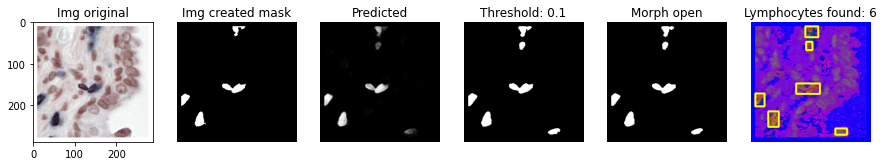

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.0
Dice coefficient is: 0.0


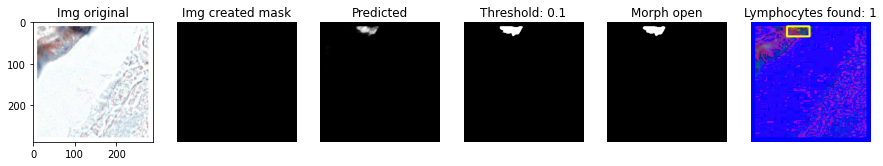

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.8888888955116272
Dice coefficient is: 0.9411764705882353


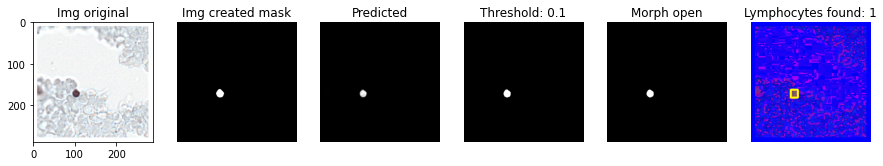

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.4455544352531433
Dice coefficient is: 0.6164478230822391


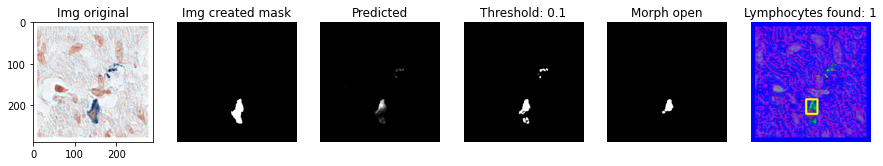

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.8061959743499756
Dice coefficient is: 0.89270043877144


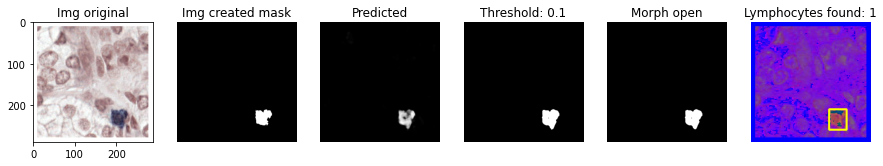

Jaccard coefficient is: 1.0
Dice coefficient is: 1.0


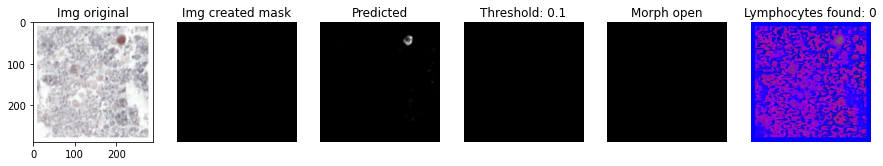

Jaccard coefficient is: 0.0
Dice coefficient is: 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


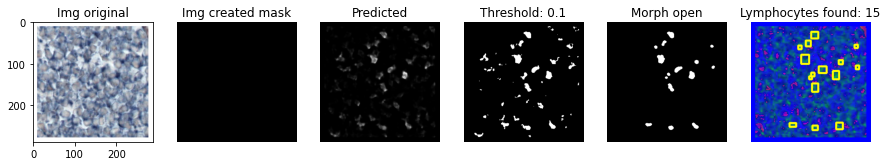

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Jaccard coefficient is: 0.9437869787216187
Dice coefficient is: 0.9710806697108066


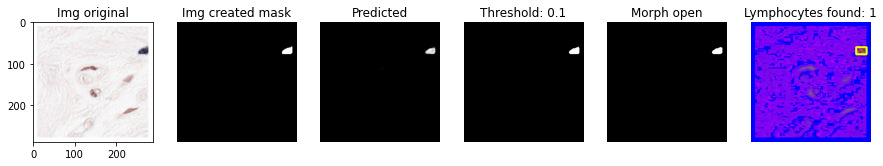

In [0]:
index = 0
batch = 8
gen_eval = Datagenerator(test_ids, test_path, batch, c_space='hsv')
gen_eval_rgb = Datagenerator(test_ids, test_path, batch, c_space='rgb')
x,y = gen_eval.__getitem__(index)
x_rgb,y_rgb = gen_eval_rgb.__getitem__(index)
print(x.shape,y.shape)
result2 = model.predict(x)


for i in range(0, len(x)):

    #Bounding box to orig img:
    orig = x[i].copy()
    new = np.zeros((288,288), dtype=np.uint8)
    tmp = result2[i].copy()
    tmp = tmp.reshape(288,288)
    threshold = 0.1
    pos = tmp >= threshold
    neg = tmp < threshold
    new[pos] = 255
    new[neg] = 0

    morphed = morph_open(new, 7)

    cnt, _ = cv2.findContours(image=morphed,
                              mode=cv2.RETR_EXTERNAL,
                              method=cv2.CHAIN_APPROX_SIMPLE)
    bin = np.zeros((288,288), dtype=np.uint8)
    bin = cv2.drawContours(bin, cnt, -1, (255, 255, 255), cv2.FILLED)

    ex = []
    for c in cnt:
      if cv2.contourArea(c) > 10:
        ex.append(c)

    for c in ex:
      a,b,c,d = cv2.boundingRect(c)
      cv2.rectangle(orig, (a,b),(a+c,b+d),(255,255,0),4)

    print('Jaccard coefficient is: {:2}'.format(jaccard(bin,y[i].reshape(288,288))))
    print('Dice coefficient is: {:2}'.format(dice(bin,y[i].reshape(288,288))))

    fig, rows = plt.subplots(nrows=1, ncols=6, figsize=(15,15))
    rows[0].imshow(x_rgb[i])
    rows[0].set_title('Img original')
    rows[1].imshow(y[i].reshape(288,288), cmap='gray')
    rows[1].set_title('Img created mask')
    rows[1].axis('off')
    rows[2].imshow(result2[i].reshape(288,288), cmap='gray')
    rows[2].set_title('Predicted')
    rows[2].axis('off')
    rows[3].imshow(new, cmap='gray')
    rows[3].set_title('Threshold: {}'.format(threshold))
    rows[3].axis('off')
    rows[4].imshow(morphed, cmap='gray')
    rows[4].set_title('Morph open')
    rows[4].axis('off')
    rows[5].imshow(orig)
    rows[5].set_title('Lymphocytes found: {}'.format(len(ex)))
    rows[5].axis('off')

    plt.show()
    #plt.savefig('/content/gdrive/My Drive/Lystox_data/Unet/Unet/' + 'test_data_' + str(i) +'.png')

# SLIDING WINDOW



In [0]:
wsi_roi_10 = '/content/gdrive/My Drive/Lystox_data/Unet/Unet/Data/WSI/'
wsi_ids = next(os.walk(wsi_roi_10))[1] #All eval ids directories
wsi_ids

['ROI_10', 'ROI_99', 'ROI_113']

In [0]:
index = 0
batch = 1
gen_eval = Datagenerator(wsi_ids, wsi_path, batch, c_space='lab')
x,y = gen_eval.__getitem__(index)
print(x.shape,y.shape)

(1, 666, 847, 3) (1,)


In [0]:
def reshape_2_3D(wsi):
  return wsi.reshape(wsi.shape[1], wsi.shape[2], wsi.shape[3])

In [0]:
def reload_wsi(index=0, c_space='rgb'):
  if c_space == 'rgb':
    gen = Datagenerator(wsi_ids, wsi_path, batch, c_space='rgb')
  elif c_space == 'hsv':
     gen = Datagenerator(wsi_ids, wsi_path, batch, c_space='hsv')
  else:
     gen = Datagen(wsi_ids, wsi_path, batch, c_space='lab')

  x,y = gen.__getitem__(index)
  x = reshape_2_3D(x)
  return x

In [0]:
x = reload_wsi(index, 'lab')

In [0]:
x = x.copy()
step = 288
x_w = int(x.shape[1] / step) + 1 if x.shape[1] % step != 0 else int(x.shape[1] / step)
x_h = int(x.shape[0] / step) + 1 if x.shape[0] % step != 0 else int(x.shape[0] / step)
print(x_h,x_w)

3 3


(666, 847, 3)


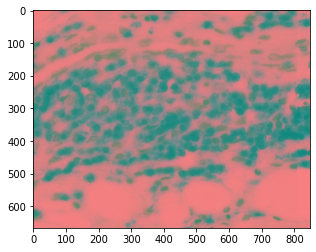

In [0]:
print(x.shape)
plt.imshow(x)

In [0]:
sliding_win_size = (288,288)

def sliding_window(x, stepSize=288, windowSize=(288,288)):
	for i in range(0, x.shape[0], stepSize):
		for j in range(0, x.shape[1], stepSize):
			print("aaa")
			yield (x[i:i + stepSize, j:j + stepSize, :])

In [0]:
def img_from_slide(x, pieces, step=288, windowSize=(288,288)):
  print(f'X shape: {x.shape}')

  x_w = int(x.shape[1] / step) + 1 if x.shape[1] % step != 0 else int(x.shape[1] / step)
  x_h = int(x.shape[0] / step) + 1 if x.shape[0] % step != 0 else int(x.shape[0] / step)

  print(f'x_w: {x_w} x_h: {x_h}')
  dst = np.zeros((x_h*step,x_w*step), dtype=np.uint8)

  slice = np.array(pieces)
  print(f'New size: {x_h} * {x_w}')
  print(f'Slice shape: {slice.shape}')

  for k,i in enumerate(range(0,dst.shape[0]-1, step)):
    for l,j in enumerate(range(0, dst.shape[1]-1,step)):
      print(k,l)
      print(f'K*x_w + l: {k*x_w + l}')
      dst[i:i + step, j:j+step] =  slice[k * x_w + l,]

  dst = dst[0:x.shape[0], 0:x.shape[1]]
  return dst

In [0]:
slides = sliding_window(x)

In [0]:
new_h = x_orig.shape[0] + 288
new_w = x_orig.shape[1] + 288
results = np.zeros((new_h,new_w), dtype=np.uint8)
pieces = []
slice = np.array([])

flag = False

for o in slides:
  if o.size == (288*288*3):
    prediction = model_new.predict(o.reshape(1,288,288,3))
    flag = False
  else:
    flag = True

    #Pad rest pixel from orig img
    slice = x_orig[:288,:288,:].copy()

    width = height = 0
    height,width = o.shape[:2]
    slice[0:height,0:width,:] = o[:,:,:].copy()

    prediction = model_new.predict(slice.reshape(1,288,288,3))

  print(f'Flag: {flag}, shape: {slice.shape}')
  print(prediction.shape)
  t = threshold(prediction.reshape(288,288))

  pieces.append(t.copy())

  # fig, rows = plt.subplots(nrows=1, ncols=6, figsize=(10,10))
  # rows[0].imshow(o)
  # rows[0].set_title('RGB original')
  # rows[1].imshow(a)
  # rows[1].set_title('Lab original')
  # rows[2].imshow(slice)
  # rows[2].set_title('Filled lab original')
  # rows[3].imshow(result2.reshape(288,288), cmap='gray')
  # rows[3].set_title('Predicted')
  # rows[4].imshow(t.reshape(288,288), cmap='gray')
  # rows[4].set_title('Thresholded')
  # rows[5].imshow(morph_open(t.reshape(288,288),7), cmap='gray')
  # rows[5].set_title('Morphed')

aaa
Flag: False, shape: (0,)
(1, 288, 288, 1)
aaa
Flag: False, shape: (0,)
(1, 288, 288, 1)
aaa
Flag: True, shape: (288, 288, 3)
(1, 288, 288, 1)
aaa
Flag: False, shape: (288, 288, 3)
(1, 288, 288, 1)
aaa
Flag: False, shape: (288, 288, 3)
(1, 288, 288, 1)
aaa
Flag: True, shape: (288, 288, 3)
(1, 288, 288, 1)
aaa
Flag: True, shape: (288, 288, 3)
(1, 288, 288, 1)
aaa
Flag: True, shape: (288, 288, 3)
(1, 288, 288, 1)
aaa
Flag: True, shape: (288, 288, 3)
(1, 288, 288, 1)


In [0]:
for i in pieces:
  print(i.shape)

(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)


In [0]:
np.array(pieces).shape

(9, 288, 288)

In [0]:
x = x_orig.copy()
x_w = int(x.shape[1] / step) + 1 if x.shape[1] % step != 0 else int(x.shape[1] / step)
x_h = int(x.shape[0] / step) + 1 if x.shape[0] % step != 0 else int(x.shape[0] / step)
print(x_h,x_w)
results = np.zeros((x_h*288,x_w*288), dtype=np.uint8)
results.shape

3 3


(864, 864)

In [0]:
whole = img_from_slide(x_orig, pieces, step=288)

X shape: (666, 847, 3)
x_w: 3 x_h: 3
New size: 3 * 3
Slice shape: (9, 288, 288)
0 0
K*x_w + l: 0
0 1
K*x_w + l: 1
0 2
K*x_w + l: 2
1 0
K*x_w + l: 3
1 1
K*x_w + l: 4
1 2
K*x_w + l: 5
2 0
K*x_w + l: 6
2 1
K*x_w + l: 7
2 2
K*x_w + l: 8


In [0]:
whole.shape

(666, 847)

In [0]:
cp = x_orig.copy()
cnt, _ = cv2.findContours(image=whole,
                          mode=cv2.RETR_EXTERNAL,
                          method=cv2.CHAIN_APPROX_SIMPLE)

ex = []
for c in cnt:
  if cv2.contourArea(c) > 10:
    ex.append(c)

for c in ex:
  a,b,c,d = cv2.boundingRect(c)
  cv2.rectangle(cp, (a,b),(a+c,b+d),(255,255,0), 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Found Lymphocytes 128')

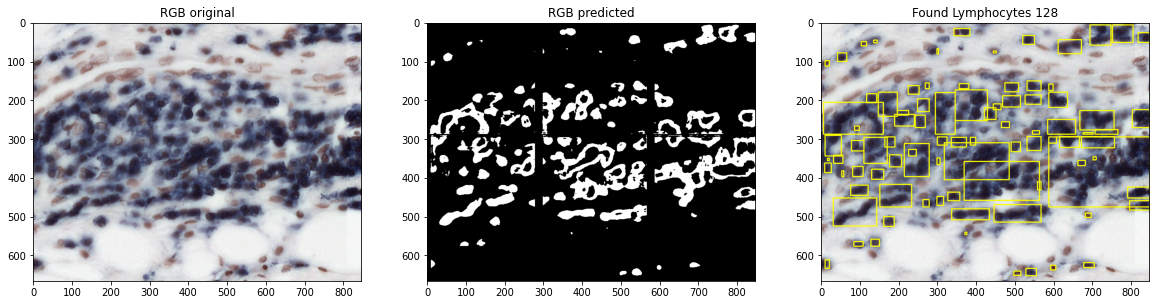

In [0]:
fig, rows = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
rows[0].imshow(x_orig)
rows[0].set_title('RGB original')
rows[1].imshow(whole, cmap='gray')
rows[1].set_title('RGB predicted')
rows[2].imshow(cp)
rows[2].set_title(f'Found Lymphocytes {len(cnt)}')

# WSI 2

In [0]:
index = 2
batch = 1
gen_eval = Datagenerator(wsi_ids, wsi_path, batch, c_space='lab')
gen_orig = Datagenerator(wsi_ids, wsi_path, batch, c_space='rgb')
x_orig,y_orig = gen_orig.__getitem__(index)
x,y = gen_eval.__getitem__(index)
print(x.shape,x_orig.shape)


(1, 1728, 2200, 3) (1, 1728, 2200, 3)


In [0]:
x_orig = reload_wsi(index, 'rgb')
x = reload_wsi(index, 'lab')

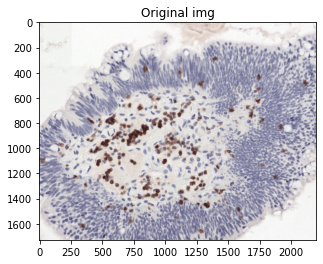

In [0]:
plt.title('Original img')
plt.imshow(cv2.cvtColor(np.array(x_orig, dtype=np.float32), cv2.COLOR_BGR2RGB))

In [0]:
img = sliding_window(x)
orig = sliding_window(x_orig)

In [0]:
new_h = x_orig.shape[0] + 288
new_w = x_orig.shape[1] + 288
results = np.zeros((new_h,new_w), dtype=np.uint8)
pieces = []
slice = []
width = 0
height = 0
flag = False

for o,a in zip(orig,img):
  if o.size == (288*288*3):
    result2 = model_new.predict(o.reshape(1,288,288,3))
    slice = o.copy()
    flag = False
  else:
    flag = True

    #Fill existing pixel
    slice = x_orig[:288,:288,:].copy()
    print('In other ',slice.shape)
    global width,height
    width,height = o.shape[:2]
    slice[0:width,0:height,:] = o[:,:,:].copy()
    result2 = model_new.predict(slice.reshape(1,288,288,3))
  print(result2.shape)
  t = threshold(result2.reshape(288,288))

  # if flag:
  #   pieces.append(t[0:width,0:height].copy())
  # else:
  #   pieces.append(t.copy())
  pieces.append(t.copy())

  # fig, rows = plt.subplots(nrows=1, ncols=6, figsize=(10,10))
  # rows[0].imshow(o)
  # rows[0].set_title('RGB original')
  # rows[1].imshow(a)
  # rows[1].set_title('Lab original')
  # rows[2].imshow(slice)
  # rows[2].set_title('Filled lab original')
  # rows[3].imshow(result2.reshape(288,288), cmap='gray')
  # rows[3].set_title('Predicted')
  # rows[4].imshow(t.reshape(288,288), cmap='gray')
  # rows[4].set_title('Thresholded')
  # rows[5].imshow(morph_open(t.reshape(288,288),7), cmap='gray')
  # rows[5].set_title('Morphed')

aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
In other  (288, 288, 3)
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
In other  (288, 288, 3)
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
In other  (288, 288, 3)
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
In other  (288, 288, 3)
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa
aaa
(1, 288, 288, 1)
aaa


In [0]:
for p in pieces:
  print(p.shape)


(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)
(288, 288)


In [0]:
whole = img_from_slide(x_orig, pieces)

X shape: (1728, 2200, 3)
x_w: 8 x_h: 6
New size: 6 * 8
Slice shape: (47, 288, 288)
0 0
K*x_w + l: 0
0 1
K*x_w + l: 1
0 2
K*x_w + l: 2
0 3
K*x_w + l: 3
0 4
K*x_w + l: 4
0 5
K*x_w + l: 5
0 6
K*x_w + l: 6
0 7
K*x_w + l: 7
1 0
K*x_w + l: 8
1 1
K*x_w + l: 9
1 2
K*x_w + l: 10
1 3
K*x_w + l: 11
1 4
K*x_w + l: 12
1 5
K*x_w + l: 13
1 6
K*x_w + l: 14
1 7
K*x_w + l: 15
2 0
K*x_w + l: 16
2 1
K*x_w + l: 17
2 2
K*x_w + l: 18
2 3
K*x_w + l: 19
2 4
K*x_w + l: 20
2 5
K*x_w + l: 21
2 6
K*x_w + l: 22
2 7
K*x_w + l: 23
3 0
K*x_w + l: 24
3 1
K*x_w + l: 25
3 2
K*x_w + l: 26
3 3
K*x_w + l: 27
3 4
K*x_w + l: 28
3 5
K*x_w + l: 29
3 6
K*x_w + l: 30
3 7
K*x_w + l: 31
4 0
K*x_w + l: 32
4 1
K*x_w + l: 33
4 2
K*x_w + l: 34
4 3
K*x_w + l: 35
4 4
K*x_w + l: 36
4 5
K*x_w + l: 37
4 6
K*x_w + l: 38
4 7
K*x_w + l: 39
5 0
K*x_w + l: 40
5 1
K*x_w + l: 41
5 2
K*x_w + l: 42
5 3
K*x_w + l: 43
5 4
K*x_w + l: 44
5 5
K*x_w + l: 45
5 6
K*x_w + l: 46
5 7
K*x_w + l: 47


IndexError: ignored

In [0]:
whole.shape

(666, 847)

In [0]:
cp = x_orig.copy()
cnt, _ = cv2.findContours(image=whole,
                          mode=cv2.RETR_EXTERNAL,
                          method=cv2.CHAIN_APPROX_SIMPLE)

ex = []
for c in cnt:
  if cv2.contourArea(c) > 10:
    ex.append(c)

for c in ex:
  a,b,c,d = cv2.boundingRect(c)
  cv2.rectangle(cp, (a,b),(a+c,b+d),(255,0,0), 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Found Lymphocytes 200')

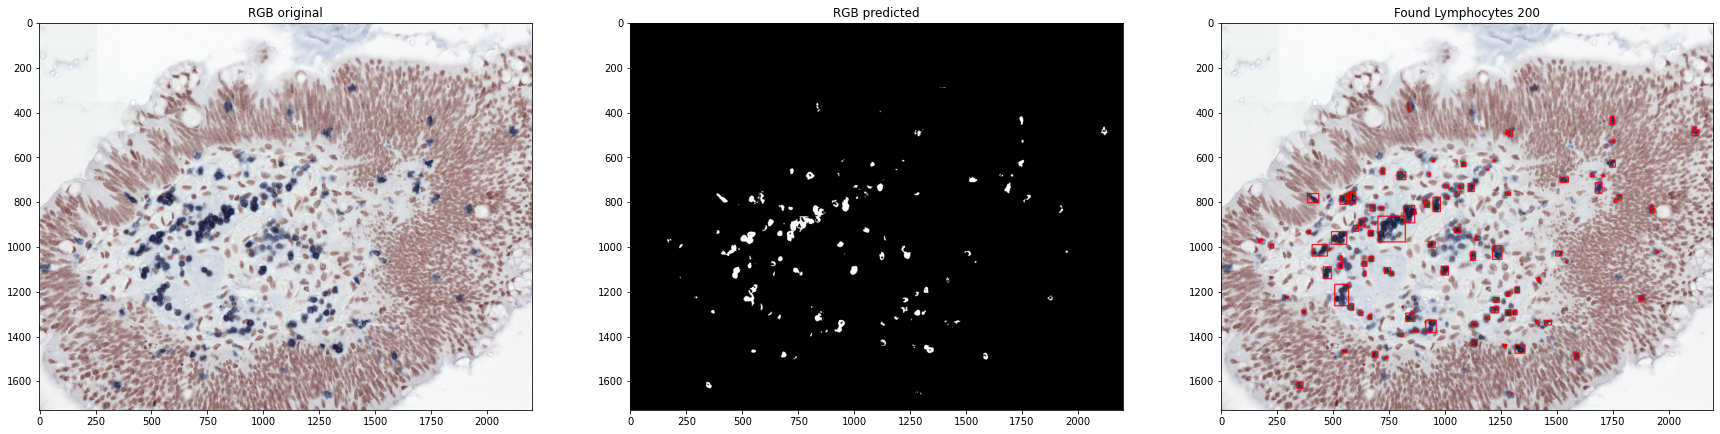

In [0]:
fig, rows = plt.subplots(nrows=1, ncols=3, figsize=(30,30))
rows[0].imshow(x_orig)
rows[0].set_title('RGB original')
rows[1].imshow(whole, cmap='gray')
rows[1].set_title('RGB predicted')
rows[2].imshow(cp)
rows[2].set_title(f'Found Lymphocytes {len(cnt)}')

# WSI 3

In [0]:
index = 1
batch = 1
gen_eval = Datagenerator(wsi_ids, wsi_path, batch, c_space='lab')
gen_orig = Datagenerator(wsi_ids, wsi_path, batch, c_space='rgb')
x_orig,y_orig = gen_orig.__getitem__(index)
x,y = gen_eval.__getitem__(index)
print(x.shape,x_orig.shape)

(1, 1526, 2223, 3) (1, 1526, 2223, 3)


In [0]:
x_orig = reload_wsi(index, 'rgb')
x = reload_wsi(index, 'lab')

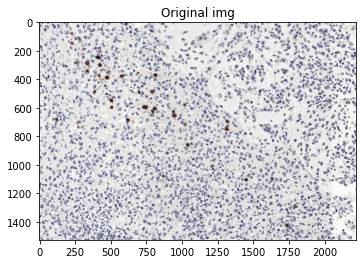

In [0]:
plt.title('Original img')
plt.imshow(cv2.cvtColor(np.array(x_orig, dtype=np.float32), cv2.COLOR_BGR2RGB))

In [0]:
img = sliding_window(x)
orig = sliding_window(x_orig)

In [0]:
new_h = x_orig.shape[0] + 288
new_w = x_orig.shape[1] + 288

pieces = []
slice = []
width = 0
height = 0
flag = False

for o,a in zip(orig,img):
  if o.size == (288*288*3):
    result2 = model_new_lab.predict(o.reshape(1,288,288,3))
    slice = o.copy()
    flag = False
  else:
    flag = True

    #Fill existing pixel
    slice = x_orig[:288,:288,:].copy()
    print('In other ',slice.shape)
    global width,height
    width,height = o.shape[:2]
    slice[0:width,0:height,:] = o[:,:,:].copy()
    result2 = model_new_lab.predict(slice.reshape(1,288,288,3))
  print(result2.shape)
  t = threshold(result2.reshape(288,288))

  # if flag:
  #   pieces.append(t[0:width,0:height].copy())
  # else:
  #   pieces.append(t.copy())
  pieces.append(t.copy())

  # fig, rows = plt.subplots(nrows=1, ncols=6, figsize=(10,10))
  # rows[0].imshow(o)
  # rows[0].set_title('RGB original')
  # rows[1].imshow(a)
  # rows[1].set_title('Lab original')
  # rows[2].imshow(slice)
  # rows[2].set_title('Filled lab original')
  # rows[3].imshow(result2.reshape(288,288), cmap='gray')
  # rows[3].set_title('Predicted')
  # rows[4].imshow(t.reshape(288,288), cmap='gray')
  # rows[4].set_title('Thresholded')
  # rows[5].imshow(morph_open(t.reshape(288,288),7), cmap='gray')
  # rows[5].set_title('Morphed')

(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
In other  (288, 288, 3)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
In other  (288, 288, 3)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
In other  (288, 288, 3)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
In other  (288, 288, 3)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
(1, 288, 288, 1)
In other  (288, 288, 3)
(1, 288, 288, 1)
In other  (288, 288, 3)
(1, 288, 288, 1)
In other  (288, 288, 3)
(1, 288, 288, 1)
In other  (288, 288, 3)
(1, 288, 288, 1)
In other  (288, 288, 3)
(1, 288, 288, 1)
In other  (288, 288, 3)
(1, 288, 288

In [0]:
whole = img_from_slide(x_orig, pieces)

X shape: (1526, 2223, 3)
New size: 6 * 8
Slice shape: (48, 288, 288)


In [0]:
whole.shape

(1526, 2223)

In [0]:
cp = x_orig.copy()
cnt, _ = cv2.findContours(image=whole,
                          mode=cv2.RETR_EXTERNAL,
                          method=cv2.CHAIN_APPROX_SIMPLE)

ex = []
for c in cnt:
  if cv2.contourArea(c) > 10:
    ex.append(c)

for c in ex:
  a,b,c,d = cv2.boundingRect(c)
  cv2.rectangle(cp, (a,b),(a+c,b+d),(255,0,0), 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Found Lymphocytes 116')

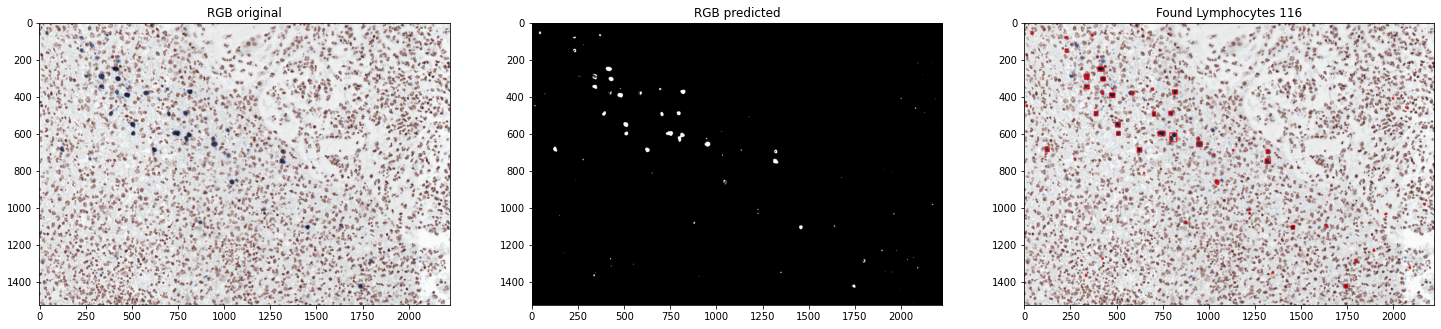

In [0]:
fig, rows = plt.subplots(nrows=1, ncols=3, figsize=(25,25))
rows[0].imshow(x_orig)
rows[0].set_title('RGB original')
rows[1].imshow(whole, cmap='gray')
rows[1].set_title('RGB predicted')
rows[2].imshow(cp)
rows[2].set_title(f'Found Lymphocytes {len(cnt)}')

# MODEL EVALUATION

In [0]:
def evaluate_model(y,y_pred, batch, thresh_val, elem_size):
  d_list = []
  j_list = []


  for i in range(0, batch):

      #Threshold predicted
      new = np.zeros((288,288), dtype=np.uint8)
      tmp = y_pred[i].copy()
      tmp = tmp.reshape(288,288)
      threshold = thresh_val
      pos = tmp >= threshold
      neg = tmp < threshold
      new[pos] = 255
      new[neg] = 0

      morphed = morph_open(new, elem_size)
      cnt, _ = cv2.findContours(image=morphed,
                              mode=cv2.RETR_EXTERNAL,
                              method=cv2.CHAIN_APPROX_SIMPLE)
      bin = np.zeros((288,288), dtype=np.uint8)
      bin = cv2.drawContours(bin, cnt, -1, (255, 255, 255), cv2.FILLED)

      r1 = dice(bin, y[i].reshape(288,288))
      r2 = jaccard(bin, y[i].reshape(288,288))
      # print(f"Dice: {r1}")
      # print(f"Dice: {r2}")
      d_list.append(r1)
      j_list.append(r2)



  avg_dice = sum(d_list) / len(d_list)
  max_dice = max(d_list)
  min_dice = min(d_list)

  avg_jacc = sum(j_list) / len(j_list)
  max_jacc = max(j_list)
  min_jacc = min(j_list)

  res = [avg_dice, max_dice, min_dice]
  print("Dice values: ", d_list)


  print(f'Avg dice score: {avg_dice}')
  print(f'Avg jacc score: {avg_jacc}')

  return avg_dice * 100, min_dice*100, max_dice*100, avg_jacc * 100,min_jacc*100,max_jacc*100


# Models Results


In [0]:
cols = ['Model Type', 'Dropout', 'Avg Dice' ,'Avg Jaccard']
data = []

RGB Model

In [0]:
index = 0
batch = 200
gen_eval = Datagenerator(test_ids, test_path, batch, c_space='rgb')
x,y = gen_eval.__getitem__(index)
print(x.shape,y.shape)
result2 = model_new.predict(x)
i,j,k,l,m,n = evaluate_model(y, result2, 200, 0.1, 7)

data.append(('model_rgb', 0.2,i,l))

(200, 288, 288, 3) (200, 288, 288, 1)
Dice values:  [0.8237327188940092, 0.0, 0.7053364269141531, 0.24514991181657847, 0.05719237435008666, 1.0, 0.0, 0.7378277153558053, 0.7018375815056312, 0.5441223319528512, 0.8699852972064692, 0.5505804311774462, 0.9588550983899821, 0.4454649827784156, 0.6825019794140934, 0.3138586956521739, 0.4225865209471767, 0.7675145024542614, 0.0, 0.0, 0.0, 0.8390596745027125, 0.0, 1.0, 0.482804526292434, 0.34023088651709865, 1.0, 0.2786259541984733, 0.7157428639202973, 0.3991683991683992, 0.6873372781065089, 0.9217877094972067, 0.7285714285714285, 0.0, 0.7117008443908324, 0.6482042405884898, 0.8023255813953488, 0.47418101054969464, 0.8717015468607825, 0.3850671140939597, 0.7112582781456953, 1.0, 0.8842159916926272, 0.7856743144935646, 0.8103448275862069, 0.8453237410071942, 0.5141752577319587, 0.8943694741740345, 0.0, 0.0, 0.0, 1.0, 0.7033084311632871, 0.6533007334963326, 0.928416485900217, 0.0, 0.8389630793401414, 0.5769728331177232, 0.7979426891991183, 0.739

LAB D 0.2 Model

In [0]:
index = 0
batch = 200
gen_eval = Datagenerator(test_ids, test_path, batch, c_space='lab')
x,y = gen_eval.__getitem__(0)
print(x.shape,y.shape)
result2 = model_new.predict(x)
i,j,k,l,m,n = evaluate_model(y, result2, 200, 0.15)

data.append(('model_lab',0.2,i,l))

(200, 288, 288, 3) (200, 288, 288, 1)
Dice values:  [0.7111390811831341, 0.0, 0.0, 0.0, 0.8877108433734939, 1.0, 1.0, 0.7723132969034608, 0.5776357827476039, 0.7884702678166137, 0.9312714776632303, 0.7515723270440252, 0.9699115044247788, 0.4143646408839779, 0.5899942495687176, 0.2305496074232691, 0.5685950413223141, 0.9192130598576811, 0.0, 1.0, 0.0, 0.9390444810543658, 0.0, 1.0, 0.44880660272139195, 0.4857372438730414, 1.0, 0.0, 0.8173598553345389, 0.0, 0.6983805668016194, 0.9232914923291492, 0.0, 0.0, 0.7194244604316546, 0.9393647738209817, 0.7879396984924623, 0.0, 0.8651911468812877, 0.3058823529411765, 0.5886901884968584, 1.0, 0.9236435060152222, 0.9010171173406103, 0.9282700421940928, 0.9006849315068494, 0.9507772020725389, 0.9118318867062586, 1.0, 1.0, 1.0, 1.0, 0.7937608318890814, 0.7086474501108647, 0.9628796400449944, 0.0, 0.9116347569955817, 0.5709177592371871, 0.8823529411764706, 0.7038724373576309, 0.9622980251346499, 0.6579400620048226, 0.9483919222139118, 0.95813397129186

In [0]:
index = 0
batch = 200
gen_eval = Datagenerator(test_ids, test_path, batch, c_space='lab')
x,y = gen_eval.__getitem__(0)
print(x.shape,y.shape)
result2 = model_new.predict(x)
i,j,k,l,m,n = evaluate_model(y, result2, 200, 0.15)

data.append(('model_lab',0.2,i,l))

(200, 288, 288, 3) (200, 288, 288, 1)
Dice values:  [0.7803433984606276, 0.0, 0.0, 0.0, 0.7074829931972789, 1.0, 0.0, 0.6438631790744467, 0.6005089058524173, 0.6412055079241361, 0.8285653740199195, 0.7859327217125383, 0.9271889400921659, 0.3760129659643436, 0.5037752944729689, 0.37467362924281983, 0.3523809523809524, 0.47706422018348627, 0.0, 1.0, 0.0, 0.8726953467954346, 0.0, 1.0, 0.4503610108303249, 0.7456931911402789, 1.0, 0.17038539553752535, 0.7652370203160271, 0.41237113402061853, 0.5625, 0.8596750369276218, 0.5984251968503937, 0.0, 0.0, 0.825589706933524, 0.8100517368810052, 0.34739454094292804, 0.6213704994192799, 0.37888198757763975, 0.7003012048192772, 1.0, 0.8783505154639175, 0.8495662949194548, 0.8755555555555555, 0.9006849315068494, 0.8038617886178862, 0.8513119533527697, 0.0, 1.0, 1.0, 1.0, 0.704225352112676, 0.7912984364377974, 0.6114457831325302, 0.0, 0.9066666666666666, 0.8571428571428571, 0.8457993619283942, 0.7463070006422607, 0.45060018467220686, 0.6111111111111112,

LAB D 0.3 Model

In [0]:
index = 0
batch = 200
gen_eval = Datagenerator(test_ids, test_path, batch, c_space='lab')
x,y = gen_eval.__getitem__(0)
print(x.shape,y.shape)
result2 = model_new.predict(x)
i,j,k,l,m,n = evaluate_model(y, result2, 200, 0.15, 9)

data.append(('model_lab',0.2,i,l)) #Change drop to 0.3

(200, 288, 288, 3) (200, 288, 288, 1)
Dice values:  [0.9040816326530612, 0.0, 0.8494845360824742, 0.4215530903328051, 0.7065803667745415, 1.0, 0.0, 0.8439108061749572, 0.8006230529595015, 0.6955691367456074, 0.7918727915194347, 0.7812080536912752, 0.9809027777777778, 0.3504885993485342, 0.7033623910336239, 0.6256771397616468, 0.616600790513834, 0.4023354564755839, 0.0, 1.0, 0.0, 0.9456609894566099, 0.0, 1.0, 0.6261110013825795, 0.7955007777910733, 1.0, 0.31401869158878504, 0.787001638448935, 0.5553470919324578, 0.7483020375549341, 0.9400798934753661, 0.834061135371179, 0.0, 0.8053691275167785, 0.8675477239353891, 0.7892845475334858, 0.5308235294117647, 0.5397269863493175, 0.3766648907831646, 0.6479925303454716, 0.0, 0.9470506270320483, 0.8703703703703703, 0.9163120567375886, 0.944078947368421, 0.4143049932523617, 0.9158460161145927, 0.0, 0.0, 0.0, 1.0, 0.5293891663465232, 0.7094505494505494, 0.7048648648648649, 0.0, 0.8678500986193294, 0.5458612975391499, 0.8288786482334869, 0.57557875

HSV D 0.2 Model

In [0]:
index = 0
batch = 200
gen_eval = Datagenerator(test_ids, test_path, batch, c_space='hsv')
x,y = gen_eval.__getitem__(0)
print(x.shape,y.shape)
result2 = model_new.predict(x)
i,j,k,l,m,n = evaluate_model(y, result2, 200, 0.15, 9)
data.append(('model_hsv', 0.2,i,l))

(200, 288, 288, 3) (200, 288, 288, 1)
Dice values:  [0.3019966722129784, 1.0, 0.0, 0.0, 0.40653873489694387, 1.0, 1.0, 0.0, 0.0, 0.4765756656555443, 0.5338230792776247, 0.0, 0.8924833491912464, 0.0, 0.4403730846102598, 0.0, 0.0, 0.7731811697574893, 0.0, 1.0, 0.0, 0.41676942046855736, 0.0, 1.0, 0.1857256566728575, 0.5232022670917463, 1.0, 0.0, 0.7648002566982192, 0.0, 0.12992125984251968, 0.37815126050420167, 0.0, 0.0, 0.0, 0.7543224768797748, 0.7548916473806018, 0.0, 0.7841105354058722, 0.0, 0.3087512291052114, 1.0, 0.546949965729952, 0.6076119905692152, 0.6225045372050817, 0.0, 0.9495412844036697, 0.5611685940353013, 1.0, 1.0, 1.0, 1.0, 0.8478260869565217, 0.12868217054263567, 0.8810679611650486, 0.0, 0.3037974683544304, 0.11526794742163801, 0.8738773916438891, 0.7106017191977078, 0.0, 0.23892773892773891, 0.4696629213483146, 0.830290736984449, 0.0, 0.7053892215568862, 0.6036927134849983, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.6117573090223201, 0.0, 0.24836601307189543, 0.8643805993203584, 0

In [0]:
data.pop(1)

('model_lab', 0.2, 54.60832898205481, 45.57391097024083)

In [0]:
results = pd.DataFrame.from_records(data=data, columns=cols)
results.head()

Model Type  Dropout  Avg Dice  Avg Jaccard
0  model_hsv      0.2  68.49802    60.601505

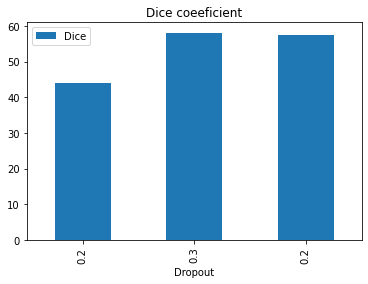

In [0]:

results.plot(kind='bar',y='Dice',x='Dropout',title='Dice coeeficient')
plt.show()